<a href="https://colab.research.google.com/github/Bhavya-2k03/ImageCaptionGenerator/blob/main/ImageCaptionGenerator(Better_Version).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Aim**

---

The aim of developing an image caption generator is to build a model that can generate a descriptive and meaningful textual description of an image.  
This has various practical applications, including assisting visually impaired individuals to better understand visual content, aiding search engines in retrieving images based on text-based queries, etc.

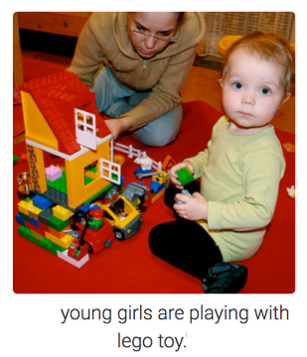

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import keras
import numpy as np
import pandas as pd
import cv2
from collections import Counter
import string
from copy import copy
from IPython.display import clear_output

In [ ]:
!pip install -U --no-cache-dir gdown --pre
clear_output()

In [ ]:
!wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
!wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip
clear_output()

In [ ]:
!unzip /content/Flickr8k_Dataset.zip
!unzip /content/Flickr8k_text.zip
clear_output()

## **Understanding the dataset**   

---



1.) Captions (Flickr8k.token.txt)
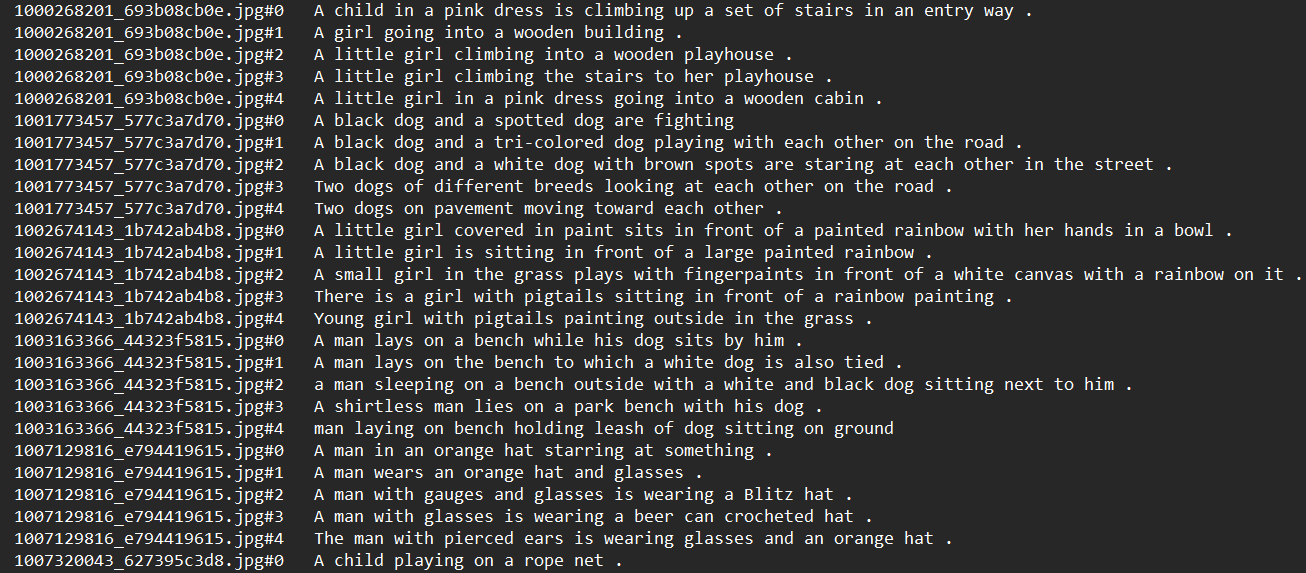

2.) Images (Flicker8k_Dataset)
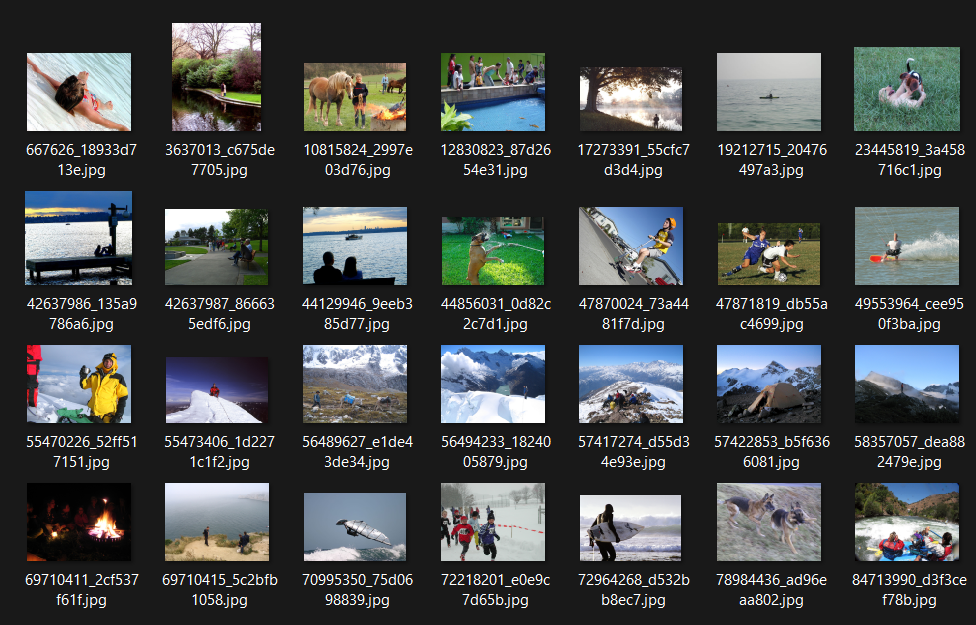





In [ ]:
dir_Flickr_jpg='/content/Flicker8k_Dataset/'
dir_Flickr_text='/content/Flickr8k.token.txt'

In [ ]:
file=open(dir_Flickr_text,"r",encoding="utf8")
text=file.read()
file.close()
a=[]
for line in text.split("\n"):
 col=line.split("\t")

 if len(col)==2:
   t=col[0].split("#")
   a.append(t+[col[1].lower()])

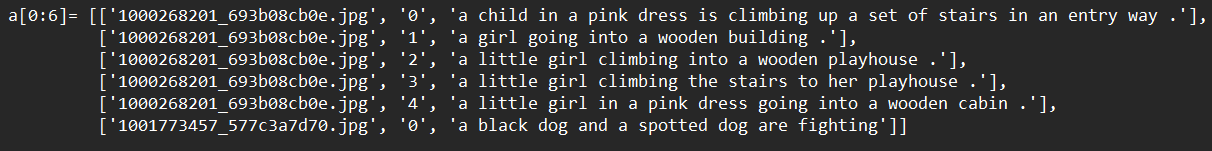

In [ ]:
df_txt=pd.DataFrame(a,columns=["filename","index","caption"])

In [ ]:
df_txt[:10]

,filename,index,caption
0,1000268201_693b08cb0e.jpg,0,a child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,1,a girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,2,a little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,3,a little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,4,a little girl in a pink dress going into a woo...
5,1001773457_577c3a7d70.jpg,0,a black dog and a spotted dog are fighting
6,1001773457_577c3a7d70.jpg,1,a black dog and a tri-colored dog playing with...
7,1001773457_577c3a7d70.jpg,2,a black dog and a white dog with brown spots a...
8,1001773457_577c3a7d70.jpg,3,two dogs of different breeds looking at each o...
9,1001773457_577c3a7d70.jpg,4,two dogs on pavement moving toward each other .


In [ ]:
unique_filenames=np.unique(df_txt.filename)

In [ ]:
from google.colab.patches import cv2_imshow

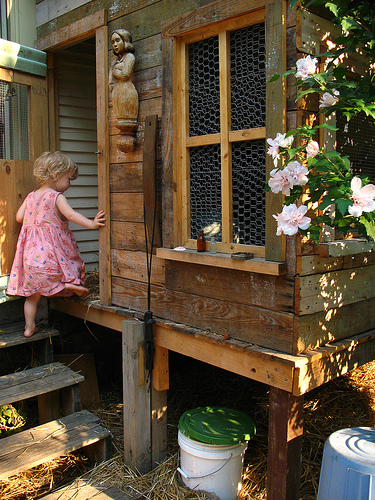

a child in a pink dress is climbing up a set of stairs in an entry way .
a girl going into a wooden building .
a little girl climbing into a wooden playhouse .
a little girl climbing the stairs to her playhouse .
a little girl in a pink dress going into a wooden cabin .


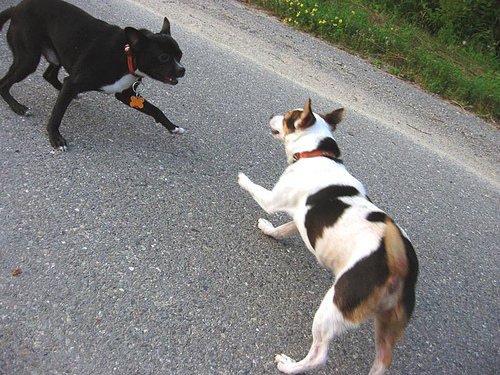

a black dog and a spotted dog are fighting
a black dog and a tri-colored dog playing with each other on the road .
a black dog and a white dog with brown spots are staring at each other in the street .
two dogs of different breeds looking at each other on the road .
two dogs on pavement moving toward each other .


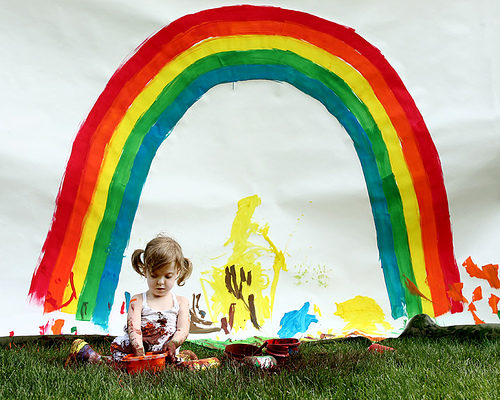

a little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .
a little girl is sitting in front of a large painted rainbow .
a small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .
there is a girl with pigtails sitting in front of a rainbow painting .
young girl with pigtails painting outside in the grass .


In [ ]:
for photo_names in unique_filenames[:3]:
  full_path=dir_Flickr_jpg+photo_names
  im_g=cv2.imread(full_path)
  cv2_imshow(im_g)
  y=-1
  for names in df_txt.filename:
    y=y+1
    if names==photo_names:
      print(df_txt.caption[y])

#Preprocessing captions for training
Captions needs to be cleaned because they can contain noise, irrelevant or redundant information that can confuse or mislead the model.

In [ ]:
def remove_punctuations(str_ing):
    for i in string.punctuation:
        str_ing=str_ing.replace(f"{i}","")
    return(str_ing)

def remove_single_char(no_punctuation_str_ing):
    text_with_no_single_char=""
    for f in no_punctuation_str_ing.split():
        if len(f)!=1:
            text_with_no_single_char+=" "+f
    return(text_with_no_single_char)

def remove_numeric(text):
  text_with_no_numeric=""
  for word in text.split():
     if word.isalpha():
       text_with_no_numeric+=" "+ word
     else:
       continue
  return(text_with_no_numeric)

def text_clean(original_text):
  text=remove_punctuations(original_text)
  text=remove_single_char(text)
  text=remove_numeric(text)
  return(text)

In [ ]:
for i,caption in enumerate(df_txt.caption):
  new_caption=text_clean(caption)
  df_txt.caption.iloc[i]=new_caption

<ipython-input-13-f8ca3ef76698>:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_txt.caption.iloc[i]=new_caption


In [ ]:
def add_start_end_seq_token(captions):
 caps=[]
 for text in captions:
   text='startseq '+text+' endseq'
   caps.append(text)
 return(caps)
df_txt0=copy(df_txt)

df_txt0.caption=add_start_end_seq_token(df_txt.caption)
del df_txt


In [ ]:
df_txt0[:5]

,filename,index,caption
0,1000268201_693b08cb0e.jpg,0,startseq child in pink dress is climbing up s...
1,1000268201_693b08cb0e.jpg,1,startseq girl going into wooden building endseq
2,1000268201_693b08cb0e.jpg,2,startseq little girl climbing into wooden pla...
3,1000268201_693b08cb0e.jpg,3,startseq little girl climbing the stairs to h...
4,1000268201_693b08cb0e.jpg,4,startseq little girl in pink dress going into...


# **Loading Pretrained VGG16**

In [ ]:
model_vgg=keras.applications.vgg16.VGG16()
clear_output()

In [ ]:
model_vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

# **Deleting the last layer of the model**

We need to delete the last layer of VGG-16 because we will be using it for feature extraction only.

In [ ]:
model_vgg2=keras.models.Sequential()
for layer in model_vgg.layers[:-1]: #iterating till last second layer
  model_vgg2.add(layer) #adding layer into our new model
model_vgg2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc2 (Dense)                          │ (None, 4096)                │      16,781,312 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from keras.applications.vgg16 import preprocess_input
from collections import OrderedDict
from tensorflow.keras.utils import load_img, img_to_array

In [ ]:
jpgs=os.listdir(dir_Flickr_jpg)
images=OrderedDict()
# data=np.zeros((len(jpgs),224,224,3))

#for inference (using saved weights (from drive)) uncomment code 1 and comment code 2
#code 1
# for img_name in jpgs:
#   images[img_name]=''

#code 2
for i,img_name in enumerate(jpgs):
    file_path=dir_Flickr_jpg+"/"+img_name
    img=load_img(file_path,target_size=(224,224,3))
    img=img_to_array(img)
    img=preprocess_input(img)
    img=img.reshape( (1,) + img.shape) #reshaping the image because we need to add batch size (i.e 1) to the image shape in order to match the input shape of vgg 16.
    y_pred = model_vgg2.predict(img)
    images[img_name]=y_pred.flatten()

In [ ]:
dimages,keepindex=[],[]
df_txt0=df_txt0.loc[df_txt0["index"].values=="0",:]
for i,filename in enumerate(df_txt0.filename):
  if filename in images.keys():
    dimages.append(images[filename])
    keepindex.append(i)
fnames=df_txt0["filename"].iloc[keepindex].values
dcaptions=df_txt0["caption"].iloc[keepindex].values
dimages=np.array(dimages)

# **Tokenizing captions for further processing**
As the model can't take texts as an input, they need to converted into vectors.



In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer=Tokenizer(num_words=6000)
tokenizer.fit_on_texts(dcaptions)
dtexts=tokenizer.texts_to_sequences(dcaptions)

In [ ]:
vocab_size=len(tokenizer.word_index)+1
maxlen=np.max([len(text) for text in dtexts])

In [ ]:
print(maxlen)

30


In [ ]:
print(vocab_size)

4476


# Splitting the dataset into Training and Testing data



In [ ]:
prop_test,prop_val=0.2,0.2
N=len(dtexts)
Ntest,Nval=int(N*prop_test),int(N*prop_val)

def split_test_val_train(dtexts,Ntest,Nval):
    return(dtexts[:Ntest],dtexts[Ntest:Ntest+Nval],dtexts[Ntest+Nval:])

In [ ]:
dt_test,dt_val,dt_train=split_test_val_train(dtexts,Ntest,Nval)
di_test,di_val,di_train=split_test_val_train(dimages,Ntest,Nval)
fnm_test,fnm_val, fnm_train=split_test_val_train(fnames,Ntest,Nval)

# Processing the captions and images as per the required shape by the model

In [ ]:
from keras.utils import pad_sequences
from tensorflow.keras.utils import to_categorical

def preprocessing(dtexts,dimages):
    N=len(dtexts)
    assert(N==len(dimages))
    Xtext,Ximage,ytext = [],[],[]
    for text,image in zip(dtexts,dimages):
        for i in range(1,len(text)):
            in_text,out_text=text[:i],text[i]
            in_text=pad_sequences([in_text],maxlen=maxlen).flatten()
            out_text=to_categorical(out_text,num_classes=vocab_size)
            Xtext.append(in_text)
            Ximage.append(image)
            ytext.append(out_text)
    Xtext=np.array(Xtext)
    Ximage=np.array(Ximage)
    ytext=np.array(ytext)
    print(" {} {} {}".format(Xtext.shape,Ximage.shape,ytext.shape))
    return(Xtext,Ximage,ytext)

Xtext_train, Ximage_train, ytext_train=preprocessing(dt_train,di_train)
Xtext_val, Ximage_val, ytext_val=preprocessing(dt_val,di_val)

 (49631, 30) (49631,) (49631, 4476)
 (16353, 30) (16353,) (16353, 4476)


In [ ]:
Ximage_train.shape

(49631, 4096)

In [ ]:
# what is the input and output
# image -> img1.jpg  caption -> "startseq A man is playing cricket endseq"

# so the trainig set wil look like this:
# trainingDataPoint1 -> img1, startseq                             output -> A
# trainingDataPoint2 -> img1, startseq A                           output -> man
# trainingDataPoint3 -> img1, startseq A man                       output -> is
# trainingDataPoint4 -> img1, startseq A man is                    output -> playing
# trainingDataPoint5 -> img1, startseq A man is playing            output -> cricket
# trainingDataPoint6 -> img1, startseq A man is playing cricket    output -> endseq




# Building the model

In [ ]:
from keras import layers,models
from keras.layers import Input,Flatten,Dropout,Activation
# from keras.layers import LeakyReLU,PReLU

dim_embedding=64
# input_image=layers.Input(shape=(Ximage_train.shape[1],))
input_image=layers.Input(shape=(4096,))
fimage=layers.Dense(256,activation='relu',name="ImageFeature")(input_image)

# input_txt=layers.Input(shape=(maxlen,))
input_txt=layers.Input(shape=(30,))
# ftxt=layers.Embedding(vocab_size,dim_embedding,mask_zero=True)(input_txt)
ftxt=layers.Embedding(4476,dim_embedding,mask_zero=True)(input_txt) #we do mask_zero=true so as to ignore values used for padding while training/inferencing
ftxt=layers.LSTM(256,name="CaptionFeature",return_sequences=True)(ftxt)
se2=Dropout(0.04)(ftxt)
ftxt=layers.LSTM(256,name="CaptionFeature2")(se2)

decoder=layers.add([ftxt,fimage])
decoder=layers.Dense(256,activation='relu')(decoder)
output=layers.Dense(4476,activation='softmax')(decoder)
# output=layers.Dense(vocab_size,activation='softmax')(decoder)

model=models.Model(inputs=[input_image, input_txt],outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam')
print(model.summary())

Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 30)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 30, 64)         │        286,464 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal (NotEqual)      │ (None, 30)             │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ CaptionFeature (LSTM)     │ (None, 30, 256)        │        328,704 │ embedding[0][0],       │
│                           │                        │                │ not_equal[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 30, 256)        │              0 │ CaptionFeature[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 4096)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ CaptionFeature2 (LSTM)    │ (None, 256)            │        525,312 │ dropout[0][0],         │
│                           │                        │                │ not_equal[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ImageFeature (Dense)      │ (None, 256)            │      1,048,832 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 256)            │              0 │ CaptionFeature2[0][0], │
│                           │                        │                │ ImageFeature[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │         65,792 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 4476)           │      1,150,332 │ dense[0][0]            │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 3,405,436 (12.99 MB)

 Trainable params: 3,405,436 (12.99 MB)

 Non-trainable params: 0 (0.00 B)

None


# Plotting model

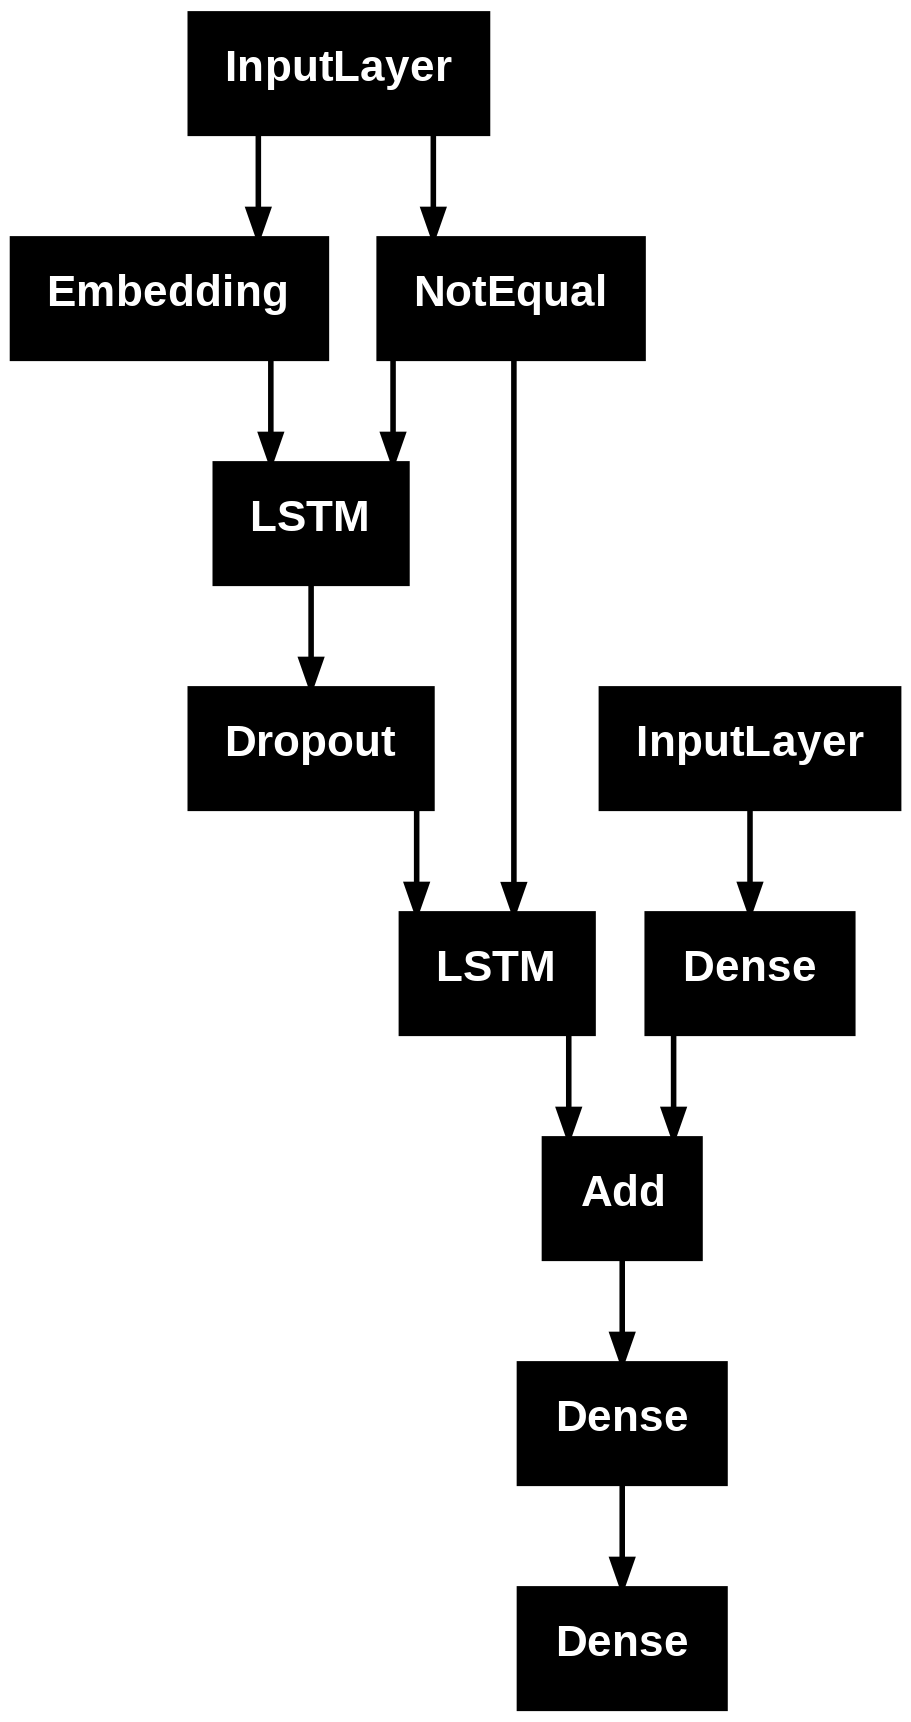

In [ ]:
tf.keras.utils.plot_model(model)

# Training

In [ ]:
hist=model.fit([Ximage_train,Xtext_train],ytext_train,epochs=5,verbose=2,batch_size=32,validation_data=([Ximage_val,Xtext_val],ytext_val))

Epoch 1/5
1551/1551 - 327s - loss: 5.3346 - val_loss: 4.8356 - 327s/epoch - 211ms/step
Epoch 2/5
1551/1551 - 292s - loss: 4.4774 - val_loss: 4.5884 - 292s/epoch - 188ms/step
Epoch 3/5
1551/1551 - 281s - loss: 4.0728 - val_loss: 4.4967 - 281s/epoch - 181ms/step
Epoch 4/5
1551/1551 - 277s - loss: 3.8067 - val_loss: 4.5294 - 277s/epoch - 179ms/step
Epoch 5/5
1551/1551 - 275s - loss: 3.5940 - val_loss: 4.5433 - 275s/epoch - 177ms/step


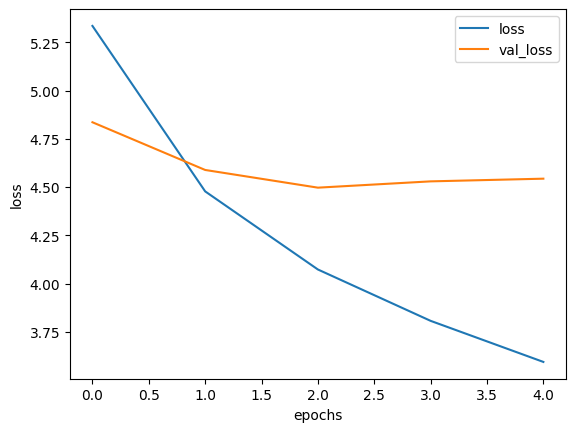

In [ ]:
for label in ["loss","val_loss"]:
    plt.plot(hist.history[label],label=label)
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
model.save("/content/")

In [ ]:
model.save_weights("/content/my_weights.h5")

# Inference

In [ ]:
!gdown --id 1-gUieho0x5zDUN8RQV8U01TPFF4y4xuH  #Downloading pretrained weights

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1-gUieho0x5zDUN8RQV8U01TPFF4y4xuH
To: /content/Image_Caption_Generator.h5
100% 40.9M/40.9M [00:00<00:00, 47.5MB/s]


In [ ]:
model.load_weights("/content/Image_Caption_Generator.h5") #Loading pretrained weights

In [ ]:
index_word=dict([(index,word) for word, index in tokenizer.word_index.items()])
def predict_caption(image):
    in_text='startseq'
    for iword in range(maxlen):
        sequence=tokenizer.texts_to_sequences([in_text])[0]
        sequence=pad_sequences([sequence],maxlen,padding='post')
        yhat=model.predict([image,sequence],verbose=0)
        yhat=np.argmax(yhat)
        newword=index_word[yhat]
        in_text+=" "+newword
        if newword=="endseq":
            break
    return(in_text)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


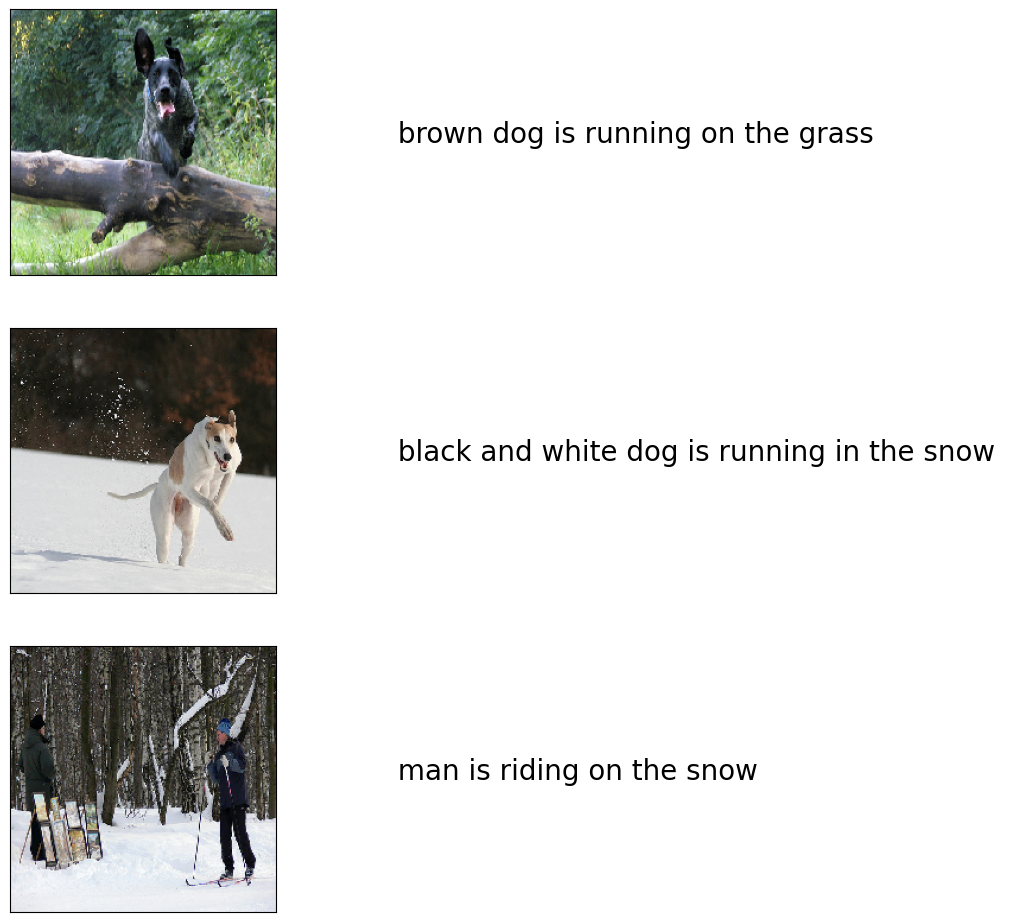

In [ ]:
count=1
fig=plt.figure(figsize=(10,20))
for jpgfnm,image_feature in zip(fnm_test[9:12],di_test[9:12]):
    filename=dir_Flickr_jpg + '/' + jpgfnm
    image_load=load_img(filename, target_size=(224,224,3))
    ax=fig.add_subplot(5,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count+=1

    img=img_to_array(image_load)
    img=preprocess_input(img)
    img=img.reshape((1,)+img.shape)
    y_pred=model_vgg2.predict(img)
    img_feature=y_pred.flatten()

    caption=predict_caption(img_feature.reshape(1,len(img_feature)))
    caption=caption.replace("startseq","")
    caption=caption.replace("endseq","")
    ax=fig.add_subplot(5,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.text(0,0.5,caption,fontsize=20)
    count+=1

plt.show()

In [ ]:
# img=load_img("/content/young.jpg",target_size=(224,224,3))
# img=img_to_array(img)
# img=preprocess_input(img)
# img=img.reshape((1,)+img.shape)
# y_pred=model_vgg2.predict(img)
# img_feature=y_pred.flatten()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


In [ ]:
# caption=predict_caption(img_feature.reshape(1,len(img_feature)))

In [ ]:
# caption=caption.replace("startseq","")
# caption=caption.replace("endseq","")

In [ ]:
# print(caption)

 girl in blue shirt is jumping on the water 


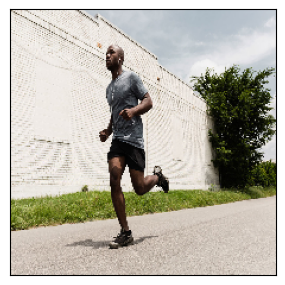

In [ ]:
# img=load_img("/content/MenRunning.jpg",target_size=(224,224,3))
# fig=plt.figure(figsize=(10,20))
# ax=fig.add_subplot(5,2,1,xticks=[],yticks=[])
# ax.imshow(img)

# Calculating BLEU (BiLingual Evaluation Understudy) score

In [ ]:
from nltk.translate.bleu_score import sentence_bleu

In [ ]:
index_word=dict([(index,word) for word, index in tokenizer.word_index.items()])
nkeep=5
bleus=[]
count=0
for jpgfnm,image_feature,tokenized_text in zip(fnm_test,di_test,dt_test):
    # count += 1
    caption_true=[index_word[i] for i in tokenized_text]
    caption_true=caption_true[1:-1]
    caption=predict_caption(image_feature.reshape(1,len(image_feature)))
    caption=caption.split()
    caption=caption[1:-1]
    bleu=sentence_bleu([caption_true],caption)
    bleus.append(bleu)

In [ ]:
print("Mean BLEU {:4.3f}".format(np.mean(bleus)))

Mean BLEU 0.372
